In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Метод ближайших соседей

Метод ближайших соседей (k Nearest Neighbors, или kNN) — один из самых понятных подходов к классификации.
Для каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:
* Вычислить расстояние до каждого из объектов обучающей выборки
* Отобрать k объектов обучающей выборки, расстояние до которых минимально
* Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди k ближайших соседей

<img src="images/knn.png">

Примечательное свойство такого подхода – его ленивость. Вычисления начинаются только в момент классификации тестового примера, а заранее, только при наличии обучающих примеров, никакая модель не строится. 

В чистом виде kNN может послужить хорошим стартом (baseline) в решении какой-либо задачи;
В соревнованиях Kaggle kNN часто используется для построения мета-признаков (прогноз kNN подается на вход прочим моделям) или в стекинге/блендинге;
Идея ближайшего соседа расширяется и на другие задачи, например, в рекомендательных системах простым начальным решением может быть рекомендация какого-то товара (или услуги), популярного среди ближайших соседей человека, которому хотим сделать рекомендацию;

Качество классификации методом ближайших соседей зависит от нескольких параметров:
* число соседей
* метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100.
* веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")

### Класс KNeighborsClassifier в Scikit-learn
Основные параметры класса [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html):
* weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
* algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем - расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автматически на основе обучающей выборки.
* leaf_size (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
* metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

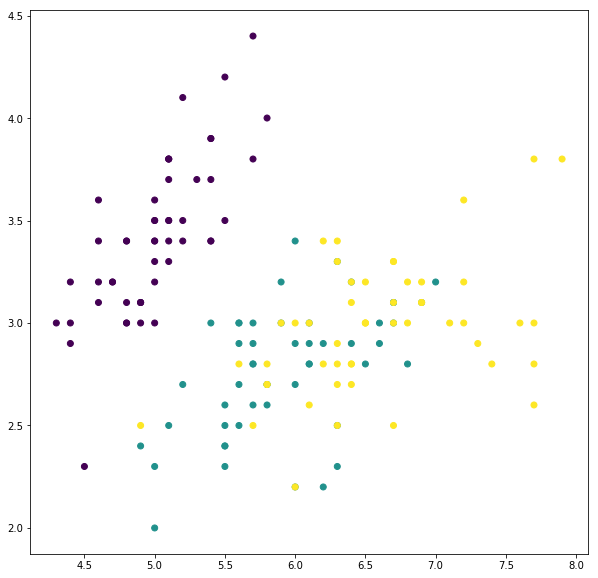

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c = y)
plt.show()

In [3]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X,y)
print(clf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


In [4]:
def get_grid(data, border = 1, step = 0.1):
    x_min, x_max = data[:,0].min()-border, data[:,0].max()+border
    y_min, y_max = data[:,1].min()-border, data[:,1].max()+border
    return np.meshgrid(np.arange(x_min,x_max, step),
                      np.arange(y_min, y_max, step))

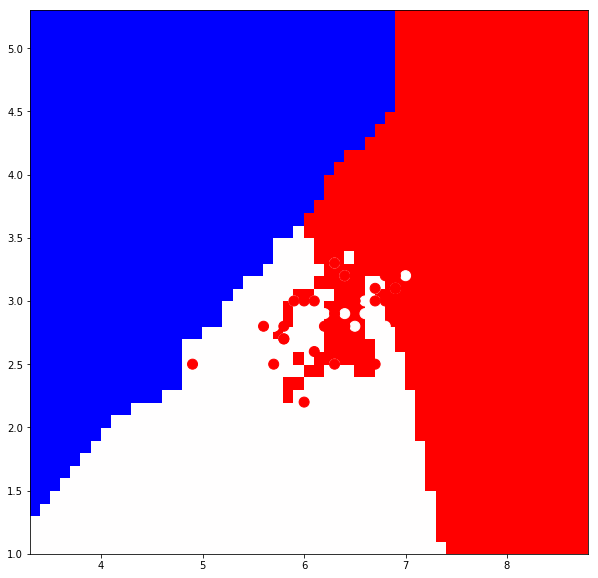

In [5]:
plt.figure(figsize=(10,10))
xx,yy = get_grid(X)
predicted = clf.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)
plt.scatter(X[:,0], X[:,1], c = y)
plt.pcolormesh(xx,yy, predicted,cmap="bwr")
plt.scatter(X[:,0],X[:,1],c=y,s=100, cmap='bwr')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
accuracy_score(y_test, KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train).predict(X_test))

0.76666666666666672

In [7]:
n = 100
scores = []
for k in range(1, n):
    scores.append(accuracy_score(y_test, KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).predict(X_test)))

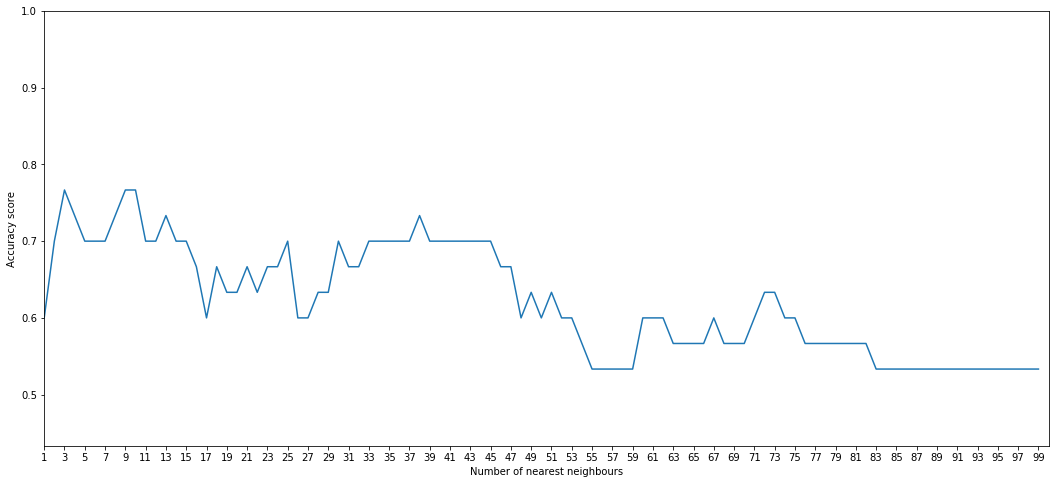

In [8]:
plt.figure(figsize=(18, 8))
plt.plot(range(1, n), scores)
plt.xlim(1, n)
plt.ylim(np.min(scores) - 0.1, 1)
plt.xticks(np.arange(1, n, 2))
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.show()

# Деревья решений

Деревья решений используются в повседневной жизни в самых разных областях человеческой деятельности, порой и очень далеких от машинного обучения. Деревом решений можно назвать наглядную инструкцию, что делать в какой ситуации.

Зачастую дерево решений служит обобщением опыта экспертов, средством передачи знаний будущим сотрудникам или моделью бизнес-процесса компании. Например, до внедрения масштабируемых алгоритмов машинного обучения в банковской сфере задача кредитного скоринга решалась экспертами. Решение о выдаче кредита заемщику принималось на основе некоторых интуитивно (или по опыту) выведенных правил, которые можно представить в виде дерева решений.

<img src="https://habrastorage.org/files/194/9b6/ae9/1949b6ae97ab4fc9b1a37fbf182eda8f.gif"/><br>
В этом случае можно сказать, что решается задача бинарной классификации (целевой класс имеет два значения: "Выдать кредит" и "Отказать") по признакам "Возраст", "Наличие дома", "Доход" и "Образование".

Дерево решений как алгоритм машинного обучения – по сути то же самое: объединение логических правил вида "Значение признака $a$ меньше $x$ И Значение признака $b$ меньше $y$ ... => Класс 1" в структуру данных "Дерево". Огромное преимущество деревьев решений в том, что они легко интерпретируемы, понятны человеку. Например, по схеме на рисунке выше можно объяснить заемщику, почему ему было отказано в кредите. Скажем, потому, что у него нет дома и доход меньше 5000. Как мы увидим дальше, многие другие, хоть и более точные, модели не обладают этим свойством и могут рассматриваться скорее как "черный ящик", в который загрузили данные и получили ответ. В связи с этой "понятностью" деревьев решений и их сходством с моделью принятия решений человеком (можно легко объяснять боссу свою модель), деревья решений получили огромную популярность, а один из представителей этой группы методов классификации, С4.5, рассматривается первым в списке 10 лучших алгоритмов интеллектуального анализа данных ("Top 10 algorithms in data mining", Knowledge and Information Systems, 2008. [PDF](http://www.cs.uvm.edu/~icdm/algorithms/10Algorithms-08.pdf)).

Еще пример: 
<img src="images/ill_tree.png"/><br>

### Механизм построения деревьев решений
В примере с кредитным скорингом мы видели, что решение о выдаче кредита принималось на основе возраста, наличия недвижимости, дохода и других. Но какой признак выбрать первым? Для этого рассмотрим пример попроще, где все признаки бинарные.

Здесь можно вспомнить игру "20 вопросов", которая часто упоминается во введении в деревья решений. Наверняка каждый в нее играл. Один человек загадывает знаменитость, а второй пытается отгадать, задавая только вопросы, на которые можно ответить "Да" или "Нет" (опустим варианты "не знаю" и "не могу сказать"). Какой вопрос отгадывающий задаст первым делом? Конечно, такой, который сильнее всего уменьшит количество оставшихся вариантов. К примеру, вопрос "Это Анджелина Джоли?" в случае отрицательного ответа оставит более 6 миллиардов вариантов для дальнейшего перебора (конечно, поменьше, не каждый человек – знаменитость, но все равно немало), а вот вопрос "Это женщина?" отсечет уже около половины знаменитостей. То есть, признак "пол" намного лучше разделяет выборку людей, чем признак "это Анджелина Джоли", "национальность-испанец" или "любит футбол". Это интуитивно соответствует понятию прироста информации, основанного на энтропии.

#### Энтропия
Энтропия Шеннона определяется для системы с $N$ возможными состояниями следующим образом:

$$\Large S = -\sum_{i=1}^{N}p_ilog_2p_i,$$

где  $p_i$ – вероятности нахождения системы в $i$-ом состоянии. Это очень важное понятие, используемое в физике, теории информации и других областях. Опуская предпосылки введения (комбинаторные и теоретико-информационные) этого понятия, отметим, что, интуитивно, энтропия соответствует степени хаоса в системе. Чем выше энтропия, тем менее упорядочена система и наоборот. Это поможет там формализовать "эффективное разделение выборки", про которое мы говорили в контексте игры "20 вопросов".

<h4>Пример</h4>
Для иллюстрации того, как энтропия поможет определить хорошие признаки для построения дерева, приведем тот же игрушечный пример, что в статье <a href="https://habrahabr.ru/post/171759/">"Энтропия и деревья принятия решений"</a>. Будем предсказывать цвет шарика по его координате. Конечно, ничего общего с жизнью это не имеет, но позволяет показать, как энтропия используется для построения дерева решений.
<img src="https://habrastorage.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png"/><br>

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью   $p_1=\frac{9}{20}$ будет синим и с вероятностью  $p_2=\frac{11}{20}$ – желтым. Значит, энтропия состояния  $S_0 = -\frac{9}{20}log_2{\frac{9}{20}}-\frac{11}{20}log_2{\frac{11}{20}} \approx 1$. Само это значение пока ни о чем нам не говорит. Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.
<img src="https://habrastorage.org/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png"/><br>

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых. Энтропия этой группы равна $S_1 = -\frac{5}{13}log_2{\frac{5}{13}}-\frac{8}{13}log_2{\frac{8}{13}} \approx 0.96$. В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых. Энтропия правой группы равна $S_2 = -\frac{1}{7}log_2{\frac{1}{7}}-\frac{6}{7}log_2{\frac{6}{7}} \approx 0.6$. Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно. Поскольку энтропия – по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют приростом информации. Формально прирост информации (information gain, IG) при разбиении выборки по признаку $Q$ (в нашем примере это признак "$x \leq 12$") определяется как 
$$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i,$$
где $q$ – число групп после разбиения, $N_i$ – число элементов выборки, у которых признак $Q$ имеет $i$-ое значение. В нашем случае после разделения получилось две группы ($q = 2$) – одна из 13 элементов ($N_1 = 13$), вторая – из 7 ($N_2 = 7$). Прирост информации получился 
$$\Large IG("x \leq 12") = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$
Получается, разделив шарики на две группы по признаку "координата меньше либо равна 12", мы уже получили более упорядоченную систему, чем в начале. Продолжим деление шариков на группы до тех пор, пока в каждой группе шарики не будут одного цвета.  
<img src="https://habrastorage.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png"/><br>
Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($log_2{1} = 0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная. 
В итоге мы построили дерево решений, предсказывающее цвет шарика по его координате. Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков), поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков). Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений, пусть даже оно и не идеально разбивает по цветам обучающую выборку. Эту проблему, переобучение, мы еще рассмотрим далее. 

#### Пример
Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Сгенерируем данные. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

In [9]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

In [10]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

Отобразим данные. Неформально, задача классификации в этом случае – построить какую-то "хорошую" границу, разделяющую 2 класса (красные точки от желтых). Если утрировать, то машинное обучение в этом случае сводится к тому, как выбрать хорошую разделяющую границу. Возможно, прямая будет слишком простой границей, а какая-то сложная кривая, огибающая каждую красную точку – будет слишком сложной и будем много ошибаться на новых примерах из того же распределения, из которого пришла обучающая выборка. Интуиция подсказывает, что хорошо на новых данных будет работать какая-то гладкая граница, разделяющая 2 класса, или хотя бы просто прямая (в  nn -мерном случае - гиперплоскость).

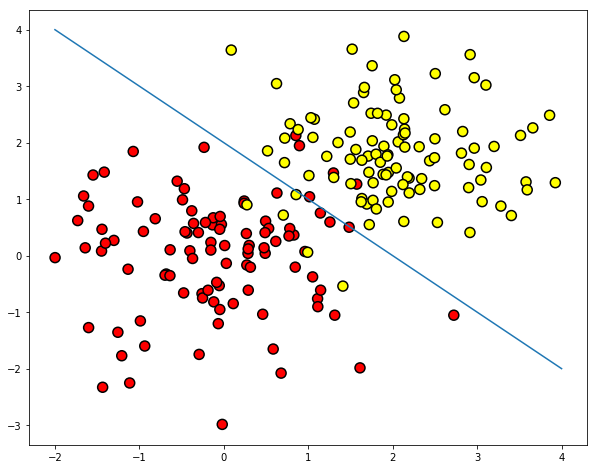

In [11]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1));
plt.show()

Попробуем разделить эти два класса, обучив дерево решений. В дереве будем использовать параметр max_depth, ограничивающий глубину дерева. Визуализируем полученную границу разделения класссов.

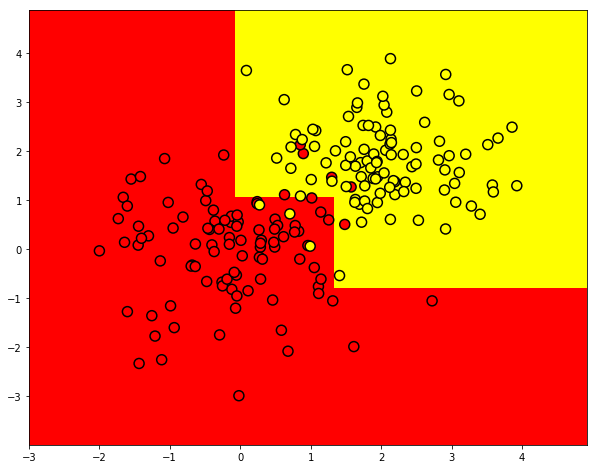

In [12]:
from sklearn.tree import DecisionTreeClassifier

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

А как выглядит само построенное дерево? Видим, что дерево "нарезает" пространство на 7 прямоугольников (в дереве 7 листьев). В каждом таком прямоугольнике прогноз дерева будет константным, по превалированию объектов того или иного класса.

In [13]:
# используем .dot формат для визуализации дерева
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file='small_tree.dot', filled=True)
!dot -Tpng 'small_tree.dot' -o 'small_tree.png'

<img src='small_tree.png'>

Как "читается" такое дерево?
В начале было 200 объектов, 100 - одного класса и 100 – другого. Энтропия начального состояния была максимальной – 1. Затем было сделано разбиение объектов на 2 группы в зависимости от сравнения признака  $x_2$  со значением  $1.0162$  (найдите этот участок границы на рисунке выше, до дерева). При этом энтропия и в левой, и в правой группе объектов уменьшилась. И так далее, дерево строится до глубины 3. При такой визуализации чем больше объектов одного класса, тем цвет вершины ближе к темно-оранжевому и, наоборот, чем больше объектов второго класса, тем ближе цвет к темно-синему. В начале объектов одного лкасса поровну, поэтому корневая вершина дерева – белого цвета.

### Основные параметры дерева

В принципе дерево решений можно построить до такой глубины, чтоб в каждом листе был ровно один объект. Но на практике это не делается из-за того, что такое дерево будет *переобученным* – оно слишком настроится на обучающую выборку и будет плохо работать на прогноз на новых данных. Где-то внизу дерева, на большой глубине будут появляться разбиения по менее важным признакам (например, приехал ли клиент из Саратова или Костромы). Если утрировать, может оказаться так, что из всех 4 клиентов, пришедших в банк за кредитом в зеленых штанах, никто не вернул кредит. Но мы не хотим, чтобы наша модель классификации порождала такие специфичные правила. 

Основные способы борьбы с переобучением в случае деревьев решений:
 - искусственное ограничение глубины или минимального числа объектов в листе: построение дерева просто в какой-то момент прекращается;
 - стрижка дерева (*pruning*). При таком подходе дерево сначала строится до максимальной глубины, потом постепенно, снизу вверх, некоторые вершины дерева убираются за счет сравнения по качеству дерева с данным разбиением и без него (сравнение проводится с помощью *кросс-валидации*).

### Класс DecisionTreeClassifier в Scikit-learn
Основные параметры класса [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

- `max_depth` – максимальная глубина дерева
- `max_features` - максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди *всех* признаков)
- `min_samples_leaf` – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как мимимум для 5 объектов

Параметры дерева надо настраивать в зависимости от входных данных, и делается это обычно с помощью *кросс-валидации*.


# Наивный байесовский классификатор

В основе NBC (Naïve Bayes Classifier) лежит теорема Байеса.

Теорема Байеса позволяет рассчитать апостериорную вероятность $P(c|x)$ на основе $P(c)$, $P(x)$ и $P(x|c)$.

$$ P(c | x)=\frac {P(x | c)P(c)}{P(x)} $$

где:
* $P(c|x)$ – апостериорная вероятность данного класса $c$ (т.е. данного значения целевой переменной) при данном значении признака $x$.
* $P(c)$ – априорная вероятность данного класса.
* $P(x|c)$ – правдоподобие, т.е. вероятность данного значения признака при данном классе.
* $P(x)$ – априорная вероятность данного значения признака.

В качестве примера будем рассматривать задачу классификации документов по темам.

* $P(c|x)$  — вероятность что документ $x$ принадлежит классу $c$, именно её нам надо рассчитать;
* $P(x|c)$ — вероятность встретить документ $x$ среди всех документов класса $c$;
* $P(c)$ — безусловная вероятность встретить документ класса $c$ в корпусе документов;
* $P(x)$ — безусловная вероятность документа $x$ в корпусе документов.

Теорема Байеса позволяет переставить местами причину и следствие. Зная с какой вероятностью причина приводит к некоему событию, эта теорема позволяет расчитать вероятность того что именно эта причина привела к наблюдаемому событию.

Цель классификации состоит в том чтобы понять к какому классу принадлежит документ, поэтому нам нужна не сама вероятность, а наиболее вероятный класс. Байесовский классификатор использует оценку апостериорного максимума (Maximum a posteriori estimation) для определения наиболее вероятного класса. Грубо говоря, это класс с максимальной вероятностью.

$$c_{map} = arg \max_{c\in C} \frac {P(x|c)P(c)}{P(x)}$$

То есть нам надо рассчитать вероятность для всех классов и выбрать тот класс, который обладает максимальной вероятностью. Обратите внимание, знаменатель (вероятность документа) является константой и никак не может повлиять на ранжирование классов, поэтому в нашей задаче мы можем его игнорировать.

$$c_{map} = arg\max_{c\in C} P(x|c)P(c)$$

Далее делается допущение которое и объясняет почему этот алгоритм называют наивным.

### Предположение условной независимости

Байесовский классификатор представляет документ как набор слов вероятности которых условно не зависят друг от друга. Этот подход иногда еще называется *bag of words model (мешок слов)*. Исходя из этого предположения условная вероятность документа аппроксимируется произведением условных вероятностей всех слов входящих в документ.

$$ P(x|c) \approx P(w_1|c)P(w_2|c)...P(w_n|c) = \prod_{i=1}^{n}P(w_i|c) $$

Подставив полученное выражение в предыдущую формулу мы получим:

$$c_{map} = arg\max_{c\in C} \left [P(c)\prod_{i=1}^{n}P(w_i|c)\right ]$$

### Проблема арифметического переполнения

При достаточно большой длине документа придется перемножать большое количество очень маленьких чисел. Для того чтобы при этом избежать арифметического переполнения снизу зачастую пользуются свойством логарифма произведения $log ab=log a + log b$. Так как логарифм функция монотонная, ее применение к обоим частям выражения изменит только его численное значение, но не параметры при которых достигается максимум. При этом, логарифм от числа близкого к нулю будет числом отрицательным, но в абсолютном значении существенно большим чем исходное число, что делает логарифмические значения вероятностей более удобными для анализа. Поэтому, мы переписываем нашу формулу с использованием логарифма.

$$c_{map} = arg\max_{c\in C} \left [log P(c) + \sum_{i=1}^{n}log P(w_i|c)\right ]$$

Основание логарифма в данном случае не имеет значения. Вы можете использовать как натуральный, так и любой другой логарифм.

### Оценка параметров Байесовской модели

Оценка вероятностей $P(c)$ и $P(w_i|c)$ осуществляется на обучающей выборке. Вероятность класса мы можем оценить как:
$$ P(c)=\frac{D_c}{D}$$
где, $D_c$ – количество документов принадлежащих классу $c$, а $D$ – общее количество документов в обучающей выборке.

Оценка вероятности слова в классе может делаться несколькими путями. Здесь я приведу multinomial bayes model.

$$P(w_i|c)= \frac {W_{ic}}{\sum_{i' \in V}^{}W_{i'c}}$$

* $W_{ic}$ — количество раз сколько $i$-ое слово встречается в документах класса $c$;
* $V$ — словарь корпуса документов (список всех уникальных слов).

Другими словами, числитель описывает сколько раз слово встречается в документах класса (включая повторы), а знаменатель – это суммарное количество слов во всех документах этого класса.

### Проблема неизвестных слов

С формулой выше есть одна небольшая проблема. Если на этапе классификации вам встретится слово которого вы не видели на этапе обучения, то значения $W_{ic}$, а следственно и $P(w_i|c)$ будут равны нулю. Это приведет к тому что документ с этим словом нельзя будет классифицировать, так как он будет иметь нулевую вероятность по всем классам. Избавиться от этой проблемы путем анализа большего количества документов не получится. Вы никогда не сможете составить обучающую выборку содержащую все возможные слова включая неологизмы, опечатки, синонимы и т.д. Типичным решением проблемы неизвестных слов является аддитивное сглаживание (сглаживание Лапласа). Идея заключается в том что мы притворяемся как будто видели каждое слово на один раз больше, то есть прибавляем единицу к частоте каждого слова.

$$ P(w_i|c)= \frac {W_{ic}+1}{\sum_{i'\in V}(W_{i'c}+1)} = \frac {W_{ic}+1}{|V| + \sum_{i'\in V} W_{i'c}} $$

Логически данный подход смещает оценку вероятностей в сторону менее вероятных исходов. Таким образом, слова которые мы не видели на этапе обучения модели получают пусть маленькую, но все же не нулевую вероятность.

### Собираем все вместе

Окончательная формула по которой происходит байесовская классификация:
$$c_{map} = arg\max_{c\in C} \left [log \frac{D_c}{D} + \sum_{i=1}^{n}log \frac {W_{ic}+1}{|V| + \sum_{i'\in V} W_{i'c}} \right ] $$ 

Для реализации Байесовского классификатора нам необходима обучающая выборка в которой проставлены соответствия между текстовыми документами и их классами. Затем нам необходимо собрать следующую статистику из выборки, которая будет использоваться на этапе классификации:

* относительные частоты классов в корпусе документов. То есть, как часто встречаются документы того или иного класса;
* суммарное количество слов в документах каждого класса;
* относительные частоты слов в пределах каждого класса;
* размер словаря выборки. Количество уникальных слов в выборке.

Совокупность этой информации мы будем называть моделью классификатора. Затем на этапе классификации необходимо для каждого класса рассчитать значение следующего выражения и выбрать класс с максимальным значением.

$$ log \frac{D_c}{D} + \sum_{i\in Q}log \frac {W_{ic}+1}{|V| + L_c} $$ 

в этой формуле:

* $D_c$ — количество документов в обучающей выборке принадлежащих классу $c$;
* $D$ — общее количество документов в обучающей выборке;
* $|V|$ — количество уникальных слов во всех документах обучающей выборки;
* $L_c$ — суммарное количество слов в документах класса $c$ в обучающей выборке;
* $W_{ic}$ — сколько раз $i$-ое слово встречалось в документах класса $c$ в обучающей выборке;
* $Q$ – множество слов классифицируемого документа (включая повторы).

### Реализация в Scikit-learn

Будем работать со встроенным датасетом "20 newsgroups", точнее с его частью (только 4 категории из 20 - для скорости).

Описание датасета с официального веб-сайта: 

_The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of our knowledge, it was originally collected by Ken Lang, probably for his paper “Newsweeder: Learning to filter netnews,” though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering._

In [14]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
from sklearn.datasets import fetch_20newsgroups

twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [15]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [16]:
len(twenty_train.data)

2257

In [17]:
print("\n".join(twenty_train.data[0].split("\n")))

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



In [18]:
print(twenty_train.target_names[twenty_train.target[0]])

comp.graphics


В атрибуте target хранится целевая переменная, которая представляет из себя индекс категории из списка target_names:

In [19]:
twenty_train.target[:10]

array([1, 1, 3, 3, 3, 3, 3, 2, 2, 2])

In [20]:
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

comp.graphics
comp.graphics
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
sci.med
sci.med
sci.med


#### Токенизация

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(2257, 35788)

In [22]:
count_vect.vocabulary_.get(u'algorithm')

4690

#### Tf-idf

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2257, 35788)

#### Обучение классификатора 

In [24]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=1.0).fit(X_train_tfidf, twenty_train.target)

In [25]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics


# Метод опорных векторов

Данный метод изначально относится к бинарным классификаторам, хотя существуют способы заставить его работать и для задач мультиклассификации.

### Идея метода
Даны точки на плоскости, разбитые на два класса. Проведем линию, разделяющую эти два класса. Далее, все новые точки (не из обучающей выборки) автоматически классифицируются следующим образом:
точка выше прямой попадает в класс A,
точка ниже прямой — в класс B.

<img src="https://habrastorage.org/storage/habraeffect/8c/98/8c98d4824065028420f290d88e52b40e.png"/><br>

Такую прямую назовем разделяющей прямой. В пространствах высоких размерностей необходимо рассматривать гиперплоскости — пространства, размерность которых на единицу меньше, чем размерность исходного пространства. В $\mathbb{R}^3$, например, гиперплоскость — это обычная двумерная плоскость.

В нашем примере существует несколько прямых, разделяющих два класса.

<img src="https://habrastorage.org/storage/habraeffect/7c/5f/7c5f4284e204a7c4b544a9ca175a2b13.png"/><br>



С точки зрения точности классификации лучше всего выбрать прямую, расстояние от которой до каждого класса максимально. Другими словами, выберем ту прямую, которая разделяет классы наилучшим образом. Такая прямая, а в общем случае — гиперплоскость, называется оптимальной разделяющей гиперплоскостью.

Вектора, лежащие ближе всех к разделяющей гиперплоскости, называются опорными векторами (support vectors).

### Математическая формулировка
Пусть имеется обучающая выборка: $(x_1, y_1), ...,(x_m,y_m), x_i \in \mathbb{R}^n, y_i \in {-1, 1}$.

Метод опорных векторов строит классифицирующую функцию $F$ в виде $F(x) = sign(\langle w,x\rangle+b)$, где $\langle , \rangle$ — скалярное произведение, $w$ — нормальный вектор к разделяющей гиперплоскости, $b$ — вспомогательный параметр. Те объекты, для которых $F(x) = 1$ попадают в один класс, а объекты с $F(x) = -1$ — в другой. Выбор именно такой функции неслучаен: любая гиперплоскость может быть задана в виде $\langle w,x\rangle + b = 0$ для некоторых $w$ и $b$.

<img src="https://habrastorage.org/storage/habraeffect/41/27/41273d1e28d6b6c0b7c9a42eac2be771.png"/><br>

Далее, мы хотим выбрать такие $w$ и $b$ которые максимизируют расстояние до каждого класса. Можно подсчитать, что данное расстояние равно $\frac {1}{||w||}$. Проблема нахождения максимума $\frac {1}{||w||}$ эквивалентна проблеме нахождения минимума $||w||^2$. Запишем все это в виде задачи оптимизации:

$$ \left\{\begin{matrix}
arg \min_{w,b} ||w||^2,\\ 
y_i(\langle w,x_i\rangle+b)\geq 1, i = 1, ..., m.
\end{matrix}\right.  $$

которая является стандартной задачей квадратичного программирования и решается с помощью множителей Лагранжа. Описание данного метода можно найти [в Википедии](http://en.wikipedia.org/wiki/Lagrange_multipliers).

#### Линейная неразделимость

На практике случаи, когда данные можно разделить гиперплоскостью, или, как еще говорят, линейно, довольно редки. 

В этом случае поступают так: все элементы обучающей выборки вкладываются в пространство $X$ более высокой размерности с помощью специального отображения $\varphi : \mathbb{R}^n \rightarrow X$. При этом отображение $\varphi$ выбирается так, чтобы в новом пространстве $X$ выборка была линейно разделима.

Классифицирующая функция $F$ принимает вид $F(x) = sign(\langle w,\varphi (x)\rangle+b)$. Выражение $k(x,x') = \langle \varphi (x), \varphi (x')\rangle$ называется _ядром_ классификатора. С математической точки зрения ядром может служить любая положительно определенная симметричная функция двух переменных. Положительная определенность необходимо для того, чтобы соответствующая функция Лагранжа в задаче оптимизации была ограничена снизу, т.е. задача оптимизации была бы корректно определена.

Точность классификатора зависит, в частности, от выбора ядра. На видео можно увидеть иллюстрирацию классификации при помощи полиномиального ядра: https://www.youtube.com/watch?v=3liCbRZPrZA

Чаще всего на практике встречаются следующие ядра:

* Полиномиальное: $k(x,x') = (\langle x,x'\rangle+const)^d$
* Радиальная базисная функция: $k(x,x') = e^{-\gamma ||x-x'||^2}, \gamma >0$.
* Гауссова радиальная базисная функция: $k(x,x') = e^{-\frac{||x-x'||^2}{2\sigma^2}}$. 
* Сигмоид: $k(x,x') = tanh(\kappa \langle x,x'\rangle +c), \kappa >0, c<0$.

### Класс SVC в Sklearn
Основные параметры класса [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): 
* С - регуляризатор
* kernel - ядро классификатора (‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’)
* degree - степень полинома для полиномиального ядра
* gamma - коэффициент $\gamma$ для ядер rbf’, ‘poly’ и ‘sigmoid’. По умолчанию равен 1/n_features 

In [26]:
from sklearn import svm

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

In [27]:
h = .02  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

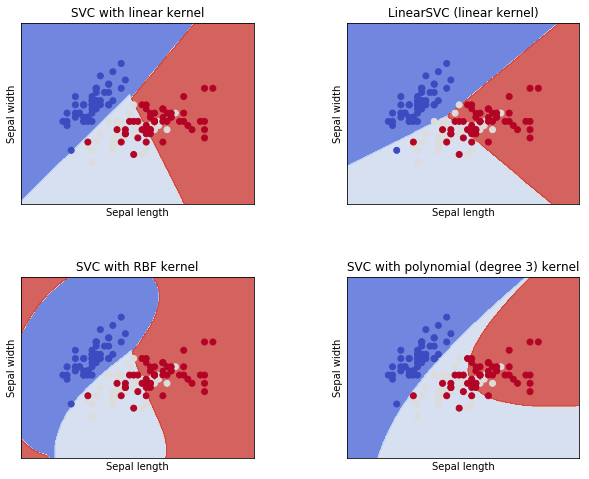

In [28]:
for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()